In [1]:
# Set to True if using Google Colab
USE_COLAB = False

if USE_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/data-valuation/
    !pip install -qr requirements.txt

Download data from here [ImageNet/CIFAR-C](https://github.com/hendrycks/robustness)

In [13]:
import math
import sys
from collections import defaultdict
from importlib import reload
from pathlib import Path

import clip
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as T
import torchvision.transforms.functional as F
from sklearn.decomposition import PCA
from torchvision.datasets import CIFAR10
from torchvision.models import ResNet18_Weights, resnet18
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm

plt.style.use("bmh")
plt.rcParams.update({"font.family": "serif"})
fig_dir = Path("../figures")

sys.path.append("../src")
from PIL import Image

import utils
import valuation
from data import simple_DS, subset

Download CIFAR-10C data from [here](https://github.com/hendrycks/robustness)

### Load embeddings

In [3]:
# saved_embedding_path = Path("CHANGE_TO_EMBEDDING_DIRECTORY")
embedding_path = Path("../embeddings")

In [37]:
embedding_dict = {
    "cifar": torch.load(embedding_path / "clip_embedding_cifar_seller.pt")["embeddings"],
    "fashion": torch.load(embedding_path / "clip_embedding_fashion_seller.pt")["embeddings"],
    "mnist": torch.load(embedding_path / "clip_embedding_mnist_seller.pt")[
        "embeddings"
    ],
    "pathmnist": torch.load(embedding_path / "clip_embedding_medmnist_PathMNIST.pt")[
        "embeddings"
    ],
    "cifar_domain": torch.load(embedding_path / "clip_embedding_cifar_domain_shift.pt")[
        "embeddings"
    ],
    "cifar_brightness": torch.load(
        embedding_path / "clip_embedding_cifar_c_brightness.pt"
    ),
    "cifar_defocus": torch.load(
        embedding_path / "clip_embedding_cifar_c_defocus_blur.pt"
    ),
    "cifar_glass_blur": torch.load(embedding_path / "clip_embedding_cifar_c_glass_blur.pt"),
    "cifar_speckle_noise": torch.load(
        embedding_path / "clip_embedding_cifar_c_speckle_noise.pt"
    ),
    "cifar_motion_blur": torch.load(
        embedding_path / "clip_embedding_cifar_c_motion_blur.pt"
    ),
    "cifar_spatter": torch.load(embedding_path / "clip_embedding_cifar_c_spatter.pt"),
    "cifar_shot_noise": torch.load(
        embedding_path / "clip_embedding_cifar_c_shot_noise.pt"
    ),
    "cifar_frost": torch.load(embedding_path / "clip_embedding_cifar_c_frost.pt"),
    "cifar_impulse_noise": torch.load(
        embedding_path / "clip_embedding_cifar_c_impulse_noise.pt"
    ),
    "cifar_contrast": torch.load(embedding_path / "clip_embedding_cifar_c_contrast.pt"),
    "cifar_gaussian_blur": torch.load(
        embedding_path / "clip_embedding_cifar_c_gaussian_blur.pt"
    ),
    "cifar_pixelate": torch.load(embedding_path / "clip_embedding_cifar_c_pixelate.pt"),
    "cifar_zoom_blur": torch.load(
        embedding_path / "clip_embedding_cifar_c_zoom_blur.pt"
    ),
    "cifar_jpeg_compression": torch.load(
        embedding_path / "clip_embedding_cifar_c_jpeg_compression.pt"
    ),
    "cifar_elastic_transform": torch.load(
        embedding_path / "clip_embedding_cifar_c_elastic_transform.pt"
    ),
    "cifar_saturate": torch.load(embedding_path / "clip_embedding_cifar_c_saturate.pt"),
    "cifar_gaussian_noise": torch.load(
        embedding_path / "clip_embedding_cifar_c_gaussian_noise.pt"
    ),
}

In [35]:
# original clean version of cifar
cifar_data = CIFAR10(root="../../data/", train=False, download=True).data

# load distribution shifted version of cifar dataset
cifar_shift_path = Path("../../data/CIFAR-10.1/datasets")
shift_data = np.load(cifar_shift_path / "cifar10.1_v4_data.npy")
shift_targets = np.load(cifar_shift_path / "cifar10.1_v4_labels.npy")

# load corrupted version of cifar test set
cifar_noise_path = Path("../../data/CIFAR-10-C")
gauss_data = np.load(cifar_noise_path / "gaussian_noise.npy")
impulse_data = np.load(cifar_noise_path / "impulse_noise.npy")
jpeg_data = np.load(cifar_noise_path / "jpeg_compression.npy")
blur_data = np.load(cifar_noise_path / "motion_blur.npy")
glass_data = np.load(cifar_noise_path / "glass_blur.npy")
contrast_data = np.load(cifar_noise_path / "contrast.npy")
bright_data = np.load(cifar_noise_path / "brightness.npy")
saturate_data = np.load(cifar_noise_path / "saturate.npy")
spatter_data = np.load(cifar_noise_path / "spatter.npy")

sharpen = lambda x: F.adjust_sharpness(T.ToPILImage()(x), 2)

Files already downloaded and verified


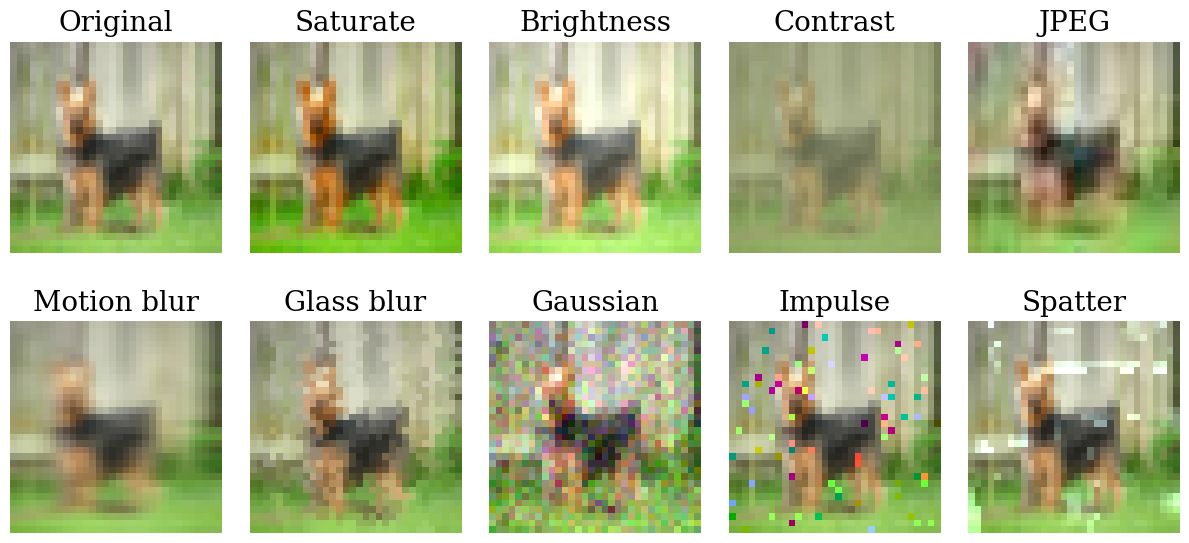

In [138]:
# image index
j = 24
sev = 2

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
ax[0, 0].imshow(cifar_data[j])
# ax[0, 1].imshow(sharpen(cifar_data[j]))
ax[0, 1].imshow(saturate_data[j + sev * 10000])
ax[0, 2].imshow(bright_data[j + sev * 10000])
ax[0, 3].imshow(contrast_data[j + sev * 10000])
ax[0, 4].imshow(jpeg_data[j + sev * 10000])
ax[1, 0].imshow(blur_data[j + sev * 10000])
ax[1, 1].imshow(glass_data[j + sev * 10000])
ax[1, 2].imshow(gauss_data[j + sev * 10000])
ax[1, 3].imshow(impulse_data[j + sev * 10000])
ax[1, 4].imshow(spatter_data[j + sev * 10000])
ax[0, 0].set_title("Original", fontsize=20, pad=8)
# ax[0, 1].set_title("Sharpened", fontsize=20, pad=8)
ax[0, 1].set_title("Saturate", fontsize=20, pad=8)
ax[0, 2].set_title("Brightness", fontsize=20, pad=8)
ax[0, 3].set_title("Contrast", fontsize=20, pad=8)
ax[0, 4].set_title("JPEG", fontsize=20, pad=8)
ax[1, 0].set_title("Motion blur", fontsize=20, pad=8)
ax[1, 1].set_title("Glass blur", fontsize=20, pad=8)
ax[1, 2].set_title("Gaussian", fontsize=20, pad=8)
ax[1, 3].set_title("Impulse", fontsize=20, pad=8)
ax[1, 4].set_title("Spatter", fontsize=20, pad=8)
ax[0, 0].axis("off")
ax[0, 1].axis("off")
ax[0, 2].axis("off")
ax[0, 3].axis("off")
ax[0, 4].axis("off")
ax[1, 0].axis("off")
ax[1, 1].axis("off")
ax[1, 2].axis("off")
ax[1, 3].axis("off")
ax[1, 4].axis("off")

fig.tight_layout(h_pad=1, w_pad=2)
plt.savefig(fig_dir / 'cifar-noise-images.eps', bbox_inches='tight')

### Embed image data through pre-trained model

In [19]:
recompute_embeddings = False
# recompute_embeddings = True

if recompute_embeddings:

    # model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
    model, preprocess = clip.load("ViT-B/16", device="cuda")
    trans = Compose([ToPILImage(), preprocess])
    model.eval()

    make_loader = lambda x, bs=32: DataLoader(
        TensorDataset(torch.tensor(x / 255).float().moveaxis(-1, 1)), batch_size=bs
    )
    embed_data = lambda x, mod: torch.cat(
        [mod(x[0].cuda()).detach().cpu() for x in tqdm(make_loader(x))]
    )

    embed_cifar_data = embed_data(cifar_data, model)
    embed_shift_data = embed_data(shift_data, model)
    embed_jpeg_data = embed_data(jpeg_data, model)
    embed_bright_data = embed_data(bright_data, model)
    embed_contrast_data = embed_data(contrast_data, model)
    embed_gauss_data = embed_data(gauss_data, model)
    embed_impulse_data = embed_data(impulse_data, model)
    embed_blur_data = embed_data(blur_data, model)
    embed_glass_data = embed_data(glass_data, model)

### Data measurements of noisy cifar data

In [38]:
corruptions = [
    "gaussian_noise",
    "impulse_noise",
    "jpeg_compression",
    "motion_blur",
    "glass_blur",
    "contrast",
    "brightness",
    "saturate",
    "spatter",
]

In [47]:
def get_value(buyer_data, seller_data, relevance="overlap", diversity="volume", n_components=10):
    values = valuation.get_measurements(buyer_data, seller_data, n_components=n_components)
    rel = values[relevance]
    div = values[diversity]
    return rel, div


# Change number of buyer components to project to calculate diversity and relevance
n_components = 10
n_buy = 1000

buyer_data = embedding_dict['cifar'][:n_buy]
seller_data = embedding_dict['cifar'][-10000:]
cifar_rel, cifar_div = get_value(buyer_data, seller_data)

corruption_measurements = {}

for corruption in tqdm(corruptions):
    print(corruption.center(40, '-'))
    seller_data = embedding_dict[f'cifar_{corruption}']
    measurements = defaultdict(list)
    # CIFAR-C dataset has 5 noise levels for each corruption
    for noise_level in tqdm(range(5)):
        s = slice(noise_level * 10000, (noise_level + 1) * 10000)
        rel, div = get_value(buyer_data, seller_data[s])
        measurements["relevance"].append(rel)
        measurements["diversity"].append(div)
    corruption_measurements[corruption] = measurements

  0%|          | 0/9 [00:00<?, ?it/s]

-------------gaussian_noise-------------


  0%|          | 0/5 [00:00<?, ?it/s]

-------------impulse_noise--------------


  0%|          | 0/5 [00:00<?, ?it/s]

------------jpeg_compression------------


  0%|          | 0/5 [00:00<?, ?it/s]

--------------motion_blur---------------


  0%|          | 0/5 [00:00<?, ?it/s]

---------------glass_blur---------------


  0%|          | 0/5 [00:00<?, ?it/s]

----------------contrast----------------


  0%|          | 0/5 [00:00<?, ?it/s]

---------------brightness---------------


  0%|          | 0/5 [00:00<?, ?it/s]

----------------saturate----------------


  0%|          | 0/5 [00:00<?, ?it/s]

----------------spatter-----------------


  0%|          | 0/5 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


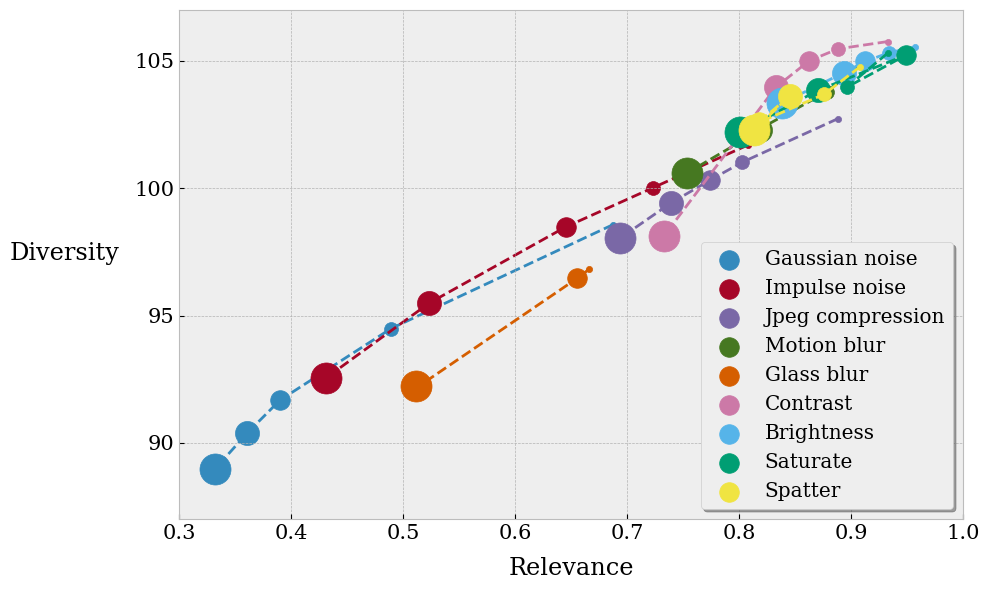

In [120]:
plt.figure(figsize=(10, 6))
for i, (k, v) in enumerate(corruption_measurements.items()):
    label = k.capitalize().replace('_', ' ')
    plt.plot(v['relevance'], v['diversity'], c=f'C{i}', ls='--', lw=2, zorder=i)
    for s, j in zip([20, 100, 200, 300, 500], range(5)):
        plt.scatter(v['relevance'][j], v['diversity'][j], s=s, c=f'C{i}', marker='o', zorder=i, label=label if j == 2 else None)

plt.xlabel('Relevance', fontsize='xx-large', labelpad=10)
plt.ylabel('Diversity', fontsize='xx-large', labelpad=50, rotation=0)
plt.xlim(0.3, 1)
plt.yticks([80, 85, 90, 95, 100, 105, 110])
plt.ylim(87, 107)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.xscale('log')
# plt.legend(fontsize='x-large', bbox_to_anchor=(1, 1))
plt.legend(fontsize='x-large', loc='lower right', shadow=True)
plt.tight_layout(w_pad=10)
plt.savefig(fig_dir / f"cifar-noise-div-rel.eps", bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


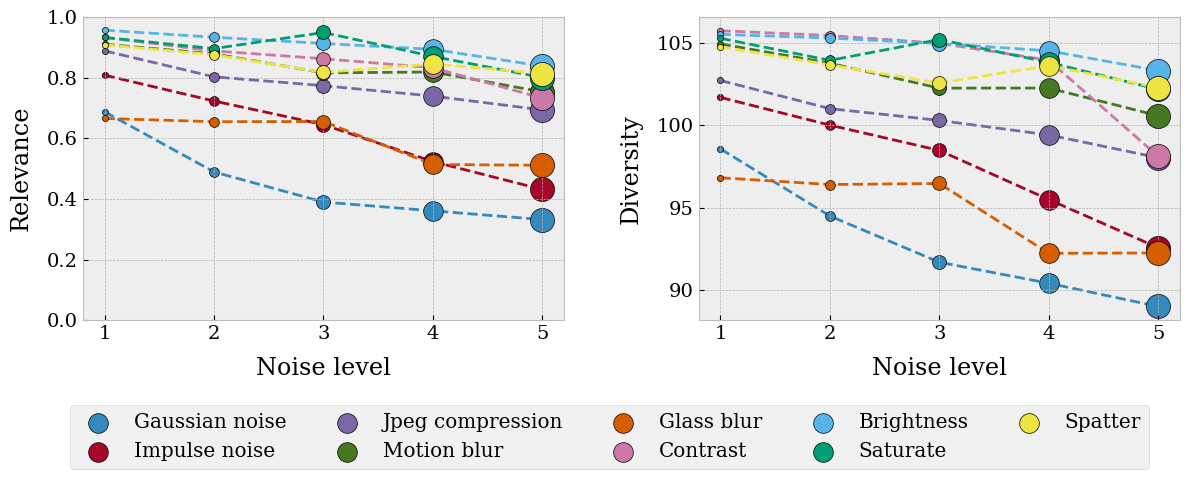

In [137]:

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for i, (k, v) in enumerate(corruption_measurements.items()):
    label = k.capitalize().replace('_', ' ')
    ax[0].plot(range(1, 6), v['relevance'], c=f'C{i}', ls='--', lw=2, zorder=i)
    ax[1].plot(range(1, 6), v['diversity'], c=f'C{i}', ls='--', lw=2, zorder=i)
    for s, j in zip([20, 50, 100, 200, 300], range(1, 6)):
        ax[0].scatter(j, v['relevance'][j - 1], c=f'C{i}',  zorder=i, marker='o', edgecolor='k', s=s)
        ax[1].scatter(j, v['diversity'][j - 1], c=f'C{i}',  zorder=i, marker='o', edgecolor='k', s=s, label=label if j == 4 else None)
    
ax[0].set_xlabel("Noise level", labelpad=10, fontsize='xx-large')
ax[0].set_ylabel("Relevance", labelpad=10, fontsize='xx-large')
# ax[0].set_xscale("log")
ax[0].set_ylim(0, 1)
ax[0].tick_params(axis='both', which='major', labelsize=14)

ax[1].set_xlabel("Noise level", labelpad=10, fontsize='xx-large')
ax[1].set_ylabel("Diversity", labelpad=10, fontsize='xx-large')
# ax[1].set_xscale("log")
ax[1].tick_params(axis='both', which='major', labelsize=14)
fig.legend(bbox_to_anchor=(0.97, 0.0), fontsize='x-large', ncols=len(corruptions)//2 + 1, fancybox=True)
fig.tight_layout(w_pad=4)
plt.savefig(fig_dir / f"cifar-vary-noise.eps", bbox_inches='tight')
plt.show()